### Load Libraries

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer, RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer


from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn import set_config
set_config(display='diagram')

### Load Data

In [8]:
data = pd.read_csv("../data/train.csv",index_col=0)
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
# check missing values
data.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

### Exploratory Data Analysis

number of survived and non_survived passengers

In [10]:
y = data['Survived']
survived = sum(y == 1)
not_survived = sum(y == 0)

print("survived : %s \nnon_survived: %s" 
     %(survived,not_survived))

survived : 342 
non_survived: 549


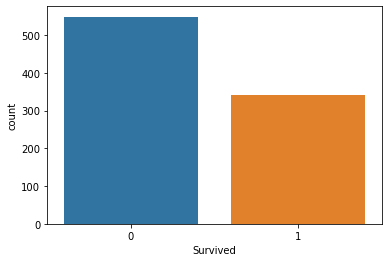

In [11]:
sns.countplot(x='Survived',data=data);

proportion of surviving 1st class passengers with regards to the total number of 1st class passengers

In [12]:
data_first_class = data [data['Pclass'] == 1] 
data_first_class_survived = data[(data['Pclass'] == 1) & (data['Survived'] == 1)]

prop = data_first_class_survived.shape[0] / data_first_class.shape[0] * 100
print(f'{round(prop,2)} percent of 1st class passengers were survived.') 

62.96 percent of 1st class passengers were survived.


Bar chart for Sex

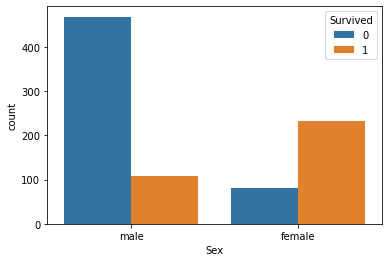

In [13]:
sns.countplot(data = data, x = 'Sex', hue = "Survived");

Bar chart for  Pclass

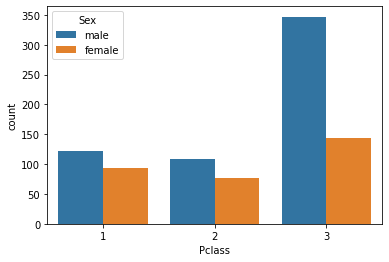

In [14]:
sns.countplot(x='Pclass',data=data,hue='Sex');

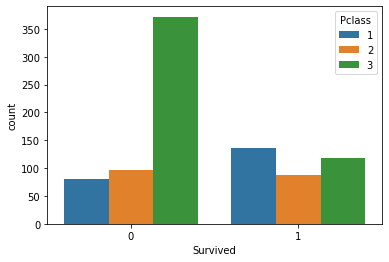

In [15]:
sns.countplot(x="Survived", data = data, hue = "Pclass");

Age distribution

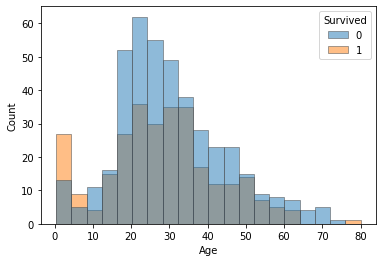

In [16]:
sns.histplot(
    data = data,
    x = "Age", hue="Survived",
    multiple='layer',
    edgecolor=".3",
    linewidth=.5,
);

In [17]:
mean_age_s = data[data['Survived'] == 1].Age.mean()
mean_age_n = data[data['Survived'] == 0].Age.mean()

print(f'average age of survived passengers is: {round(mean_age_s,2)}\naverage age of non_survived passengers is : {round(mean_age_n,2)}.')


average age of survived passengers is: 28.34
average age of non_survived passengers is : 30.63.


Fare distribution

<AxesSubplot:xlabel='Fare', ylabel='Survived'>

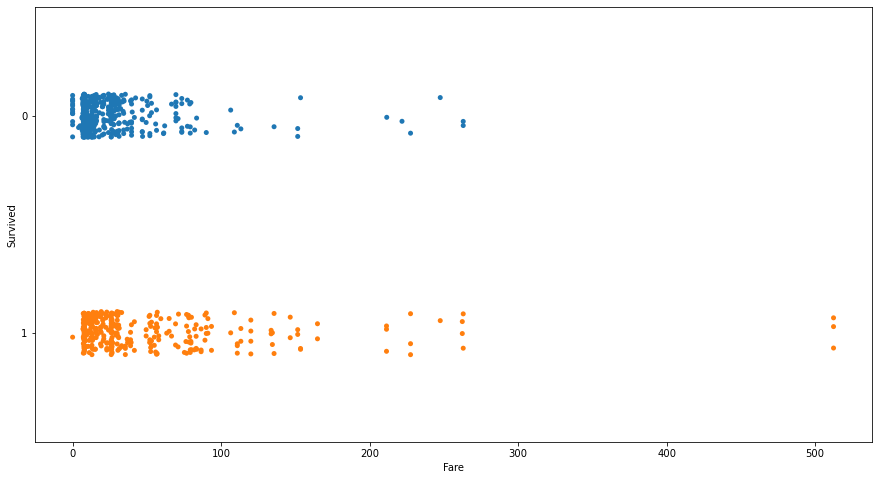

In [18]:
plt.figure(figsize=(15,8))
sns.stripplot(x=data["Fare"], y=data["Survived"].astype(str), size = 5)

Bar chart for Embarked

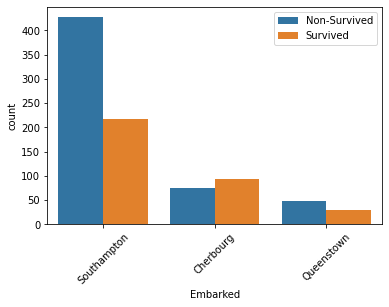

In [19]:
ax = sns.countplot(x='Embarked',data=data,hue='Survived');
ax.set_xticklabels(['Southampton','Cherbourg','Queenstown']);
plt.xticks(rotation = 45);
plt.legend(['Non-Survived', 'Survived']);

Bar chart for Relatives (SibSp + Parch)

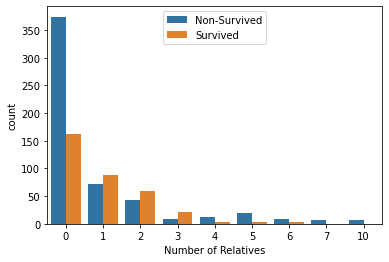

In [20]:
data['Relatives'] = data['SibSp'] + data['Parch'] 
ax = sns.countplot(x='Relatives',data=data,hue='Survived');
ax.set_xlabel("Number of Relatives")
plt.legend(['Non-Survived', 'Survived']);

Define small and large families

In [21]:
cut_bins = [-0.1,3,10]
cut_labels= ['small','big']
data['Family']= pd.cut(data['Relatives'], bins=cut_bins,labels=cut_labels,ordered = False)
data.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relatives,Family
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,small
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,small
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,small


Bar chart for family size

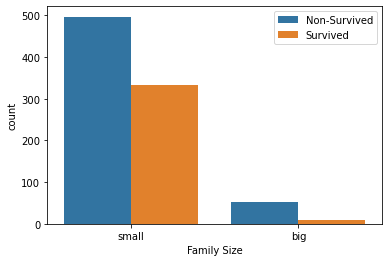

In [22]:
ax = sns.countplot(x='Family',data=data,hue='Survived');
ax.set_xlabel("Family Size")
plt.legend(['Non-Survived', 'Survived']);

In [23]:
data.groupby(["Survived","Family"]).count()[['Pclass']]

Pclass
Survived Family        
0        small      497
         big         52
1        small      332
         big         10

### Logistic Regression

In [24]:
# define features and target
X = data.drop(['Survived','SibSp','Parch','Family'], axis=1)
y = data['Survived']

In [25]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Pclass     891 non-null    int64  
 1   Name       891 non-null    object 
 2   Sex        891 non-null    object 
 3   Age        714 non-null    float64
 4   Ticket     891 non-null    object 
 5   Fare       891 non-null    float64
 6   Cabin      204 non-null    object 
 7   Embarked   889 non-null    object 
 8   Relatives  891 non-null    int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 69.6+ KB


In [26]:
# Train-test split of the data
X_train,X_test,y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=100)

#### feature engineering

In [27]:
# data summary
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Survived   891 non-null    int64   
 1   Pclass     891 non-null    int64   
 2   Name       891 non-null    object  
 3   Sex        891 non-null    object  
 4   Age        714 non-null    float64 
 5   SibSp      891 non-null    int64   
 6   Parch      891 non-null    int64   
 7   Ticket     891 non-null    object  
 8   Fare       891 non-null    float64 
 9   Cabin      204 non-null    object  
 10  Embarked   889 non-null    object  
 11  Relatives  891 non-null    int64   
 12  Family     891 non-null    category
dtypes: category(1), float64(2), int64(5), object(5)
memory usage: 91.5+ KB


**Columns and summarizing thoughts for logisitc regression:**

`Pclass`: Since it is ordinal and already numeric, keep it as it is 

`Name:` Length of name might be a useful feature

`Sex:` Categorical, but not ordinal, needs onehot encoding

`Àge:` Numerical data, impute (e.g. mean of class), needs binning 

`SibSp:` Numerical data, It is not considered in the features. Insetead of it, Relatives is considered 

`Parch:` Numerical data, It is not considered in the features. Insetead of it, Relatives is considered 

`Relatives:` Numerical data, It is sum of SibSb and Parch, needs binning 

`Ticket:` It is not considered in the Features

`Fare:` Scaling definitely needed, outliers to be considered (see box plot)

`Cabin:` Extract first letter and length of number, 

`Èmbarked:` Imputing (most frequent), needs onehot encoding

In [28]:
# Name
def name_length(df):
    length = df['Name'].str.len()
    return length.values.reshape(-1, 1)

In [29]:
# Sex, Ticket, Embarked
sex_emb_pipe = make_pipeline(
    OneHotEncoder(sparse=False, handle_unknown='ignore')
)

In [30]:
# Age
age_pipe = make_pipeline(
   SimpleImputer(strategy='mean'),
   KBinsDiscretizer(n_bins=5, encode='onehot-dense', strategy='uniform'))

In [31]:
# Relatieves
rel_pipe = make_pipeline(
   KBinsDiscretizer(n_bins=2, encode='onehot-dense', strategy='uniform')
)

In [32]:
# Fare
fare_pipe = make_pipeline(
    RobustScaler() # Handles outliers better than other scalers
)

In [33]:
# Cabin
def get_deck(df):
    # fill  values with N
    df.fillna('N',inplace = True)
    # extract deck from cabin
    deck = df.iloc[:,0].apply(lambda x: str(x)[0].upper())
    # replace T with N (T counted as unknown)
    for idx, item in deck.items():
        deck[idx] = item.replace('T', 'N')   
    return deck.values.reshape(-1,1)

cab_pipe = make_pipeline(
    FunctionTransformer(get_deck ),
    OneHotEncoder(sparse=False, handle_unknown='ignore')
)

In [34]:
# Embarked
emb_pipe = make_pipeline(
   SimpleImputer(strategy='most_frequent'),
   OneHotEncoder(sparse=False, handle_unknown='ignore')
)

In [42]:
preprocessor = ColumnTransformer([
    ('do_nothing', 'passthrough', ['Pclass']),
    ('get_string_length', FunctionTransformer(name_length), ['Name']),
    ('onehot_encoding',sex_emb_pipe,['Sex']),
    ('impute_and_binning',age_pipe,['Age']),
    ('relatives',rel_pipe,['Relatives']),
    ('scale',fare_pipe,['Fare']),
    ('get_deck',cab_pipe,['Cabin']),
    ('impute_and_onehot_encoding',emb_pipe,['Embarked'])
])

#### Create Classifier

In [43]:
# create log_reg mdoel
log_reg = make_pipeline(
    preprocessor,
    LogisticRegression(C=1e9,max_iter=3000)
)

In [83]:
log_reg.fit(X_train,y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('do_nothing', 'passthrough',
                                                  ['Pclass']),
                                                 ('get_string_length',
                                                  FunctionTransformer(func=<function name_length at 0x7fda08257670>),
                                                  ['Name']),
                                                 ('onehot_encoding',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Sex']),
                                                 ('impute_and_binning',
                                                  Pipeline...
                                                                   FunctionTransformer(func=<function get_deck at 0x7fda0825e550>)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Cabin']),
                                                 ('impute_and_onehot_encoding',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Embarked'])])),
                ('logisticregression',
                 LogisticRegression(C=1000000000.0, max_iter=3000))])

In [165]:
y_pred = log_reg.predict(X_test)

#### Evaluate classifier

/Users/milad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


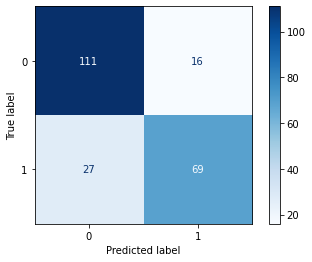

In [166]:
# plot confusion matrix
metrics.plot_confusion_matrix(log_reg, X_test, y_test,
                              values_format=".4g", 
                              cmap='Blues'
                             );

/Users/milad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


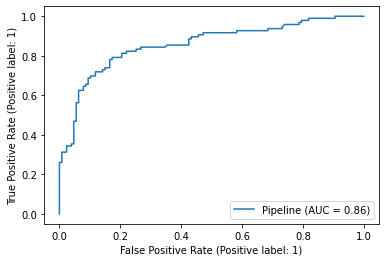

In [192]:
metrics.plot_roc_curve(log_reg, X_test, y_test)

In [167]:
def print_evaluation_metrics(model,X_train,X_test,y_train,y_test,y_pred):
    """ Print out some evaluation metrics """
    print(f'train score: {round(model.score(X_train,y_train),2)}')
    print(f'test score: {round(model.score(X_test,y_test),2)}')
    print(f'precision: {round(metrics.precision_score(y_test, y_pred, average="binary",pos_label=1),2)}') 
    print(f'recall: {round(metrics.recall_score(y_test, y_pred, average="binary",pos_label=1),2)}')
    print(f'f1: {round(metrics.f1_score(y_test, y_pred, average="binary",pos_label=1),2)}')

In [168]:
print_evaluation_metrics(log_reg,X_train,X_test,y_train,y_test,y_pred)

train score: 0.83
test score: 0.81
precision: 0.81
recall: 0.72
f1: 0.76


In [71]:
# cross validation
cross_val_score(log_reg, X_train, y_train, cv = 5, scoring='accuracy').mean()

0.8113230838289753

In [231]:
def save_evaluation_metrics(classifier,classifier_name, summary ,X_train,y_train,X_test,y_test,y_pred):
    
    summary['Classifier Name'].append(classifier_name)
    summary['Train Score'].append(round(classifier.score(X_train, y_train),2))
    summary['Test Score'].append(round(classifier.score(X_test, y_test),2))
    summary['AUC'].append(metrics.roc_auc_score(y_test,classifier.predict_proba(X_test)[:, 1]))
    summary['Precision'].append(round(metrics.precision_score(y_test, y_pred, average="binary",pos_label=1),2)) 
    summary['Recall'].append(round(metrics.recall_score(y_test, y_pred, average="binary",pos_label=1),2))
    summary['F1'].append(round(metrics.f1_score(y_test, y_pred, average="binary",pos_label=1),2))
    
    return summary

In [232]:
summary = {'Classifier Name':[],'Train Score':[],'Test Score':[],
                   'Accuracy':[],'AUC':[],'Precision':[],'Recall':[],'F1':[]}

In [233]:
summary = save_evaluation_metrics(log_reg,'Logistic Regressin',summary, X_train,y_train,X_test,y_test,y_pred)

In [234]:
summary

{'Classifier Name': ['Logistic Regressin'],
 'Train Score': [0.83],
 'Test Score': [0.81],
 'Accuracy': [],
 'AUC': [0.8571194225721785],
 'Precision': [0.81],
 'Recall': [0.72],
 'F1': [0.76]}